In [1]:
# импорт библиотек
from scipy import stats as st
import scipy.stats as stats
import pandas as pd
import numpy as np
import math 
import matplotlib.pyplot as plt
import seaborn as sns
import re
pd.options.display.float_format = '{:,.1f}'.format

In [2]:
# импорт таблицы с продажами
sales = pd.read_excel('C:/Users/Sergei/2020_portfolio_projects/sales_ToShare.xlsx', sheet_name = 'Продажи')

In [3]:
# импорт таблицы с остатками
remains = pd.read_excel('C:/Users/Sergei/2020_portfolio_projects/remains_ToShare.xlsx')

In [4]:
# вывод данных таблицы
sales.sample(3)

,Артикул старый,Размер,Месяц,"Продажи, шт."
15942,0202212620733500,XS,9,92
9746,020123126083M0/79,M,9,95
21911,010262259233S0/70,XXL,9,89


In [5]:
# вывод данных таблицы, удаление лишних символов в наименовании размера
remains['Размер'] = remains['Размер'].str.strip()
remains.sample(3)

,Артикул новый,Размер,"Остаток на складе, шт.","Себестоимость, руб.","Цена продажи, руб."
396,010213295032 6000 ...,XL,2136,1493,3464
5341,02025827Y533 59S0 ...,S,1487,1019,2354
9985,810119359275 9900 ...,L,425,381,789


In [6]:
# обработка старых индексов согласно описанию для таблицы продаж
def fix_index(row):
    old_code = row['Артикул старый']
    split_code =  old_code.split('/')
    if len(split_code[0]) == 12:
        new_code = (split_code[0] + split_code[1])
        return new_code
    if len(split_code[0]) == 14:
        new_code = (''.join(list(split_code[0])[0:12]) + split_code[1] + ''.join(list(split_code[0])[12:14]))
        return new_code
    if len(split_code[0]) == 16:
        new_code = split_code[0]
        return new_code    
    else:
        return old_code

In [7]:
# применение функции для таблицы продаж
sales['new_code'] = sales.apply(fix_index, axis = 1) 

In [8]:
sales.sample(5)

,Артикул старый,Размер,Месяц,"Продажи, шт.",new_code
37841,22023796706250D0,XS,6,90,22023796706250D0
7267,020243226063/7500,S,10,50,0202432260637500
20263,210257S5108200/50,S,6,67,210257S510825000
37819,22025718S091D0/55,27,6,82,22025718S09155D0
27299,02023327317391A0,XS,8,60,02023327317391A0


In [9]:
# проверка корректности замены по длине нового артикула
# def len_code(row):
#     lentgh = len(row['new_code'])
#     return lentgh

# sales['code_size'] = sales.apply(len_code, axis = 1)

In [10]:
# корректировка новых артикулов для таблицы с остатками
def fix_index_remains(row):
    new_code = ''.join(row['Артикул новый'].split(' '))
    return new_code

In [11]:
# применение функции для обработки новых артикулов в таблице с остатками
remains['new_code'] = remains.apply(fix_index_remains, axis = 1)

In [12]:
# sales['Размер'].value_counts()

In [13]:
# remains['Размер'].value_counts()

In [14]:
# объединение таблиц продаж и остатков
df = sales[[ 'Месяц', 'Продажи, шт.', 'new_code']].merge(remains[['Себестоимость, руб.', 
                                                                  'Цена продажи, руб.', 'new_code','Остаток на складе, шт.']],
                                                    on='new_code', how = 'outer')

In [15]:
# задаём новые названия столбцов для удобства
df.columns = ['месяц', 'продажи', 'new_code', 'себестоимость',
       'цена','остаток']

In [16]:
# предварительная оценка объединённой таблицы
df.describe()

,месяц,продажи,себестоимость,цена,остаток
count,"302,421.0","302,421.0","303,896.0","303,896.0","303,896.0"
mean,9.0,84.1,905.7,"2,266.1",488.3
std,2.0,20.0,345.8,910.2,567.8
min,6.0,2.0,300.0,602.0,1.0
25%,7.0,71.0,607.0,"1,486.0",131.0
50%,9.0,84.0,911.0,"2,250.0",310.0
75%,11.0,98.0,"1,204.0","2,959.0",635.0
max,12.0,174.0,"1,500.0","4,476.0","9,610.0"


In [17]:
# заполнение пропусков согласно условию
df['себестоимость'] = df['себестоимость'].fillna(200)
df['цена'] = df['цена'].fillna(1000)
df['продажи'] = df['продажи'].fillna(0)
df['месяц'] = df['месяц'].fillna(0)
df['остаток'] = df['остаток'].fillna(0)

In [18]:
# калькуляция суммы продаж и прибыли
df['месяц'] = df['месяц'].astype(int)
df['сумма_продаж'] = df['цена'] * df['продажи']
df['сумма_прибыли'] = df['продажи'] * (df['цена'] - df['себестоимость'])

In [19]:
# вывод значений прибыли о продаж
total_sales = df.groupby('месяц').agg({'сумма_прибыли':'sum',
         'сумма_продаж':'sum',}).reset_index().sort_values(by = 'сумма_продаж', ascending = False).dropna()
total_sales

,месяц,сумма_прибыли,сумма_продаж
3,8,"4,957,553,166.0","8,256,091,435.0"
6,11,"4,948,056,542.0","8,241,074,535.0"
2,7,"4,939,804,131.0","8,227,202,397.0"
4,9,"4,933,500,198.0","8,213,942,791.0"
7,12,"4,931,479,733.0","8,212,290,544.0"
5,10,"4,929,346,323.0","8,209,721,672.0"
1,6,"4,927,362,938.0","8,205,817,650.0"
0,0,0.0,0.0


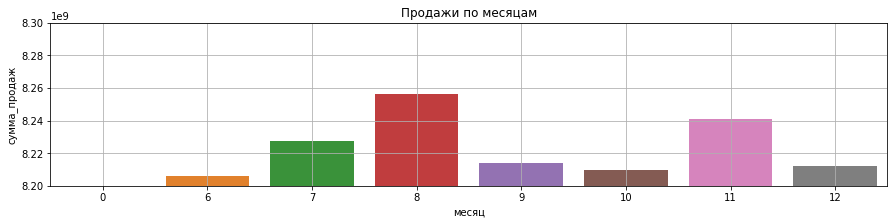

In [20]:
fig = plt.figure(figsize=(15,3))
ax = sns.barplot(x="месяц", y="сумма_продаж", data=total_sales)
plt.title('Продажи по месяцам')
plt.grid()
plt.ylim(8200000000,8300000000)
plt.show()

In [21]:
# сумма продаж в рублях за июль
print('сумма продаж в рублях за июль : ',df[df['месяц'] == 7]['сумма_продаж'].sum(),'рублей')

сумма продаж в рублях за июль :  8227202397.0 рублей


In [22]:
# сумма прибыли в рублях за октябрь
print('сумма прибыли в рублях за октябрь : ',df[df['месяц'] == 10]['сумма_прибыли'].sum(),'рублей')

сумма прибыли в рублях за октябрь :  4929346323.0 рублей


In [23]:
# находим пятый по популярности артикул в августе
print('артикул (новый), который в рейтинге продаж (в рублях) был на 5 месте в августе')
df[df['месяц'] == 8].groupby('new_code')['сумма_продаж'].sum().reset_index().sort_values(
    by = 'сумма_продаж',ascending = False).head(5).reset_index().loc[4:]

артикул (новый), который в рейтинге продаж (в рублях) был на 5 месте в августе


,index,new_code,сумма_продаж
4,837,02024717Y04255D0,"16,046,103.0"


In [24]:
# находим 10 самых популярных артикулов за август
top_10_august = df[df['месяц'] == 8].groupby('new_code')['сумма_продаж'].sum().reset_index(
).sort_values(by = 'сумма_продаж',ascending = False).head(10).reset_index()['new_code']
print('остаток на складе ТОП-10 артикулов по продажам (в рублях) в августе')
remains[remains['new_code'].isin(top_10_august)].groupby('new_code').agg(
    {'Остаток на складе, шт.':'sum'}).sort_values(by = 'Остаток на складе, шт.',
                   ascending = False)

остаток на складе ТОП-10 артикулов по продажам (в рублях) в августе


,"Остаток на складе, шт."
new_code,
02021714Z10351D0,10165
02021714Z10350D0,5152
22024712Y06350D0,5043
02024717Y04255D0,4695
02024717Y04251D0,3376
02021712Y01255D0,3042
02021714S02350D0,2932
22023714Z11351D0,2622
22023714Z11355D0,1989


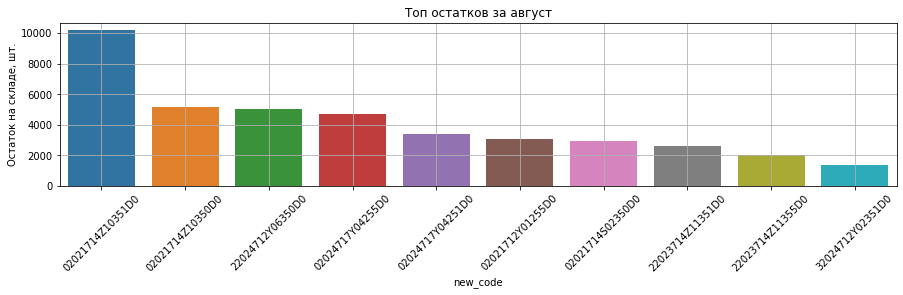

In [25]:
# визуализация топ-10 артикулов августа
fig = plt.figure(figsize=(15,3))
ax = sns.barplot(x="new_code", y="Остаток на складе, шт.",
                 data=remains[remains['new_code'].isin(top_10_august
                )].groupby('new_code').agg({'Остаток на складе, шт.':'sum'}).sort_values(by = 'Остаток на складе, шт.',
                ascending = False).reset_index())
plt.title('Топ остатков за август')
plt.grid()
plt.xticks(rotation = 45)
plt.show()

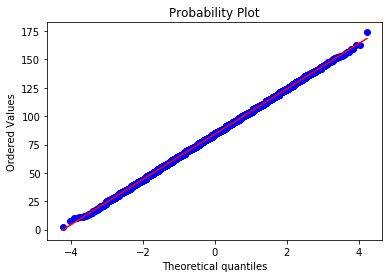

In [26]:
# проверка нормальности распределения графиком квантиль квантиль плот
import numpy as np 
import pylab 
import scipy.stats as stats

measurements = sales['Продажи, шт.']
stats.probplot(measurements, dist="norm", plot=pylab)
pylab.show()

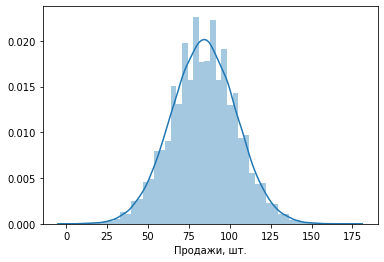

In [27]:
# распределение значений продаж
ax = sns.distplot(sales['Продажи, шт.'])

In [28]:
# не совсем понял, что такое квадратное отклонение, стандартное отклонение и дисперсию нашёл
print('Стандартное отклонение :{:.1f}'.format(np.std(sales['Продажи, шт.'])))
print('Дисперсия: {:.1f}'.format(np.var(sales['Продажи, шт.'])))

Стандартное отклонение :19.9
Дисперсия: 397.5


In [29]:
# самый простой способ оценить основные параметры распределения выборки
sales.describe()

,Месяц,"Продажи, шт."
count,"60,074.0","60,074.0"
mean,9.0,84.1
std,2.0,19.9
min,6.0,2.0
25%,7.0,71.0
50%,9.0,84.0
75%,11.0,98.0
max,12.0,174.0


In [30]:
# выводим значения продаж, входящие в диапазон две сигмы
print('95 процентов значений продаж лежат в диапазоне {:.0f} - {:.0f} шт.'.format(sales['Продажи, шт.'].quantile(0.025),
                sales['Продажи, шт.'].quantile(0.975)))

95 процентов значений продаж лежат в диапазоне 45 - 123 шт.


In [31]:
# группируем данные продаж и остатков по размерам
# для буквенных обозначений строим отдельные визуализации
sales_sizes_letter = sales[sales['Размер'].isin(['M',
    'L', 'S', 'XL', 'XS', 'XXL', 'XXXL', 'XXS'])].groupby('Размер').agg({'Продажи, шт.':'sum'}).reset_index()
sales_sizes = sales.groupby('Размер').agg({'Продажи, шт.':'sum'}).reset_index()
remains_sizes_letter = remains[remains['Размер'].isin(['M',
      'L', 'S', 'XL', 'XS', 'XXL', 'XXXL', 'XXS'])].groupby('Размер').agg({'Остаток на складе, шт.':'sum'}).reset_index()
remains_sizes = remains.groupby('Размер').agg({'Остаток на складе, шт.':'sum'}).reset_index()

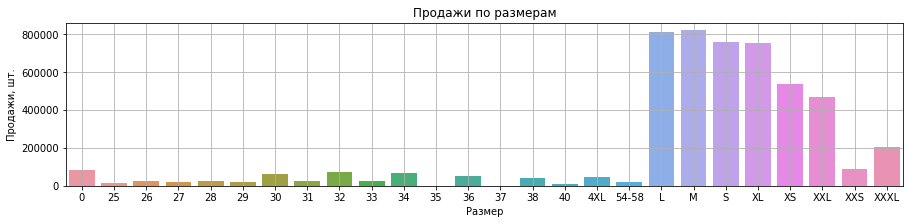

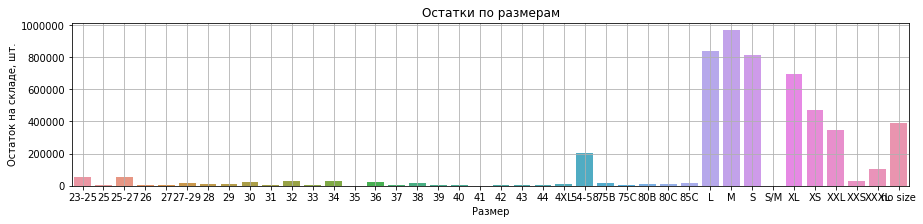

In [32]:
fig = plt.figure(figsize=(15,3))
ax = sns.barplot(x="Размер", y="Продажи, шт.", data=sales_sizes)
plt.title('Продажи по размерам')
plt.grid()
plt.show()
fig = plt.figure(figsize=(15,3))
ax = sns.barplot(x="Размер", y="Остаток на складе, шт.", data=remains_sizes)
plt.title('Остатки по размерам')
plt.grid()
plt.show()

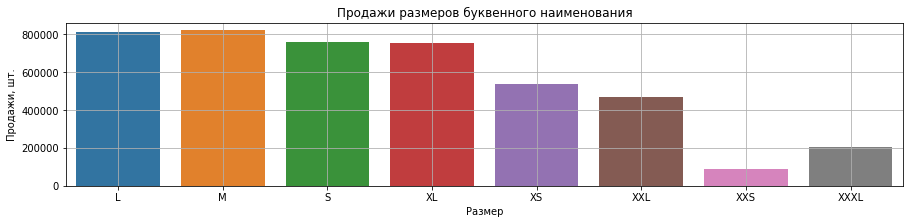

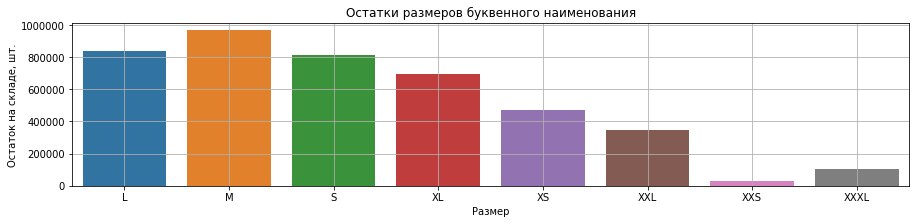

In [33]:
fig = plt.figure(figsize=(15,3))
ax = sns.barplot(x="Размер", y="Продажи, шт.", data=sales_sizes_letter)
plt.grid()
plt.title('Продажи размеров буквенного наименования')
plt.show()
fig = plt.figure(figsize=(15,3))
ax = sns.barplot(x="Размер", y="Остаток на складе, шт.", data=remains_sizes_letter)
plt.title('Остатки размеров буквенного наименования')
plt.grid()
plt.show()